# Net Demand Forecast

### Imports

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

### Read in predictions of demand, solar output, and wind output

In [65]:
demand = pd.read_csv('../datasets/demand_predictions.csv')
solar = pd.read_csv('../datasets/solar_prediction.csv')
wind = pd.read_csv('../datasets/wind_prediction.csv')

In [66]:
demand.rename(columns={'Unnamed: 0':'date','0':'demand'},inplace=True)
demand.tail(3)

,date,demand
165,2020-05-21 21:00:00,26427.913024
166,2020-05-21 22:00:00,24683.404685
167,2020-05-21 23:00:00,22923.274018


In [67]:
solar.tail(3)

,date,solar_prediction
161,2020-05-21 21:00:00,3.098171
162,2020-05-21 22:00:00,3.098171
163,2020-05-21 23:00:00,3.098171


In [68]:
wind.tail(3)

,date,wind_prediction
161,2020-05-21 21:00:00,1842.028590
162,2020-05-21 22:00:00,2040.498334
163,2020-05-21 23:00:00,2283.806863


### Merge predictions

In [78]:
predictions = demand.merge(solar,how='inner',on='date')
predictions = predictions.merge(wind,how='inner',on='date')
print(predictions.shape)
predictions.tail(3)

(164, 4)


,date,demand,solar_prediction,wind_prediction
161,2020-05-21 21:00:00,26427.913024,3.098171,1842.028590
162,2020-05-21 22:00:00,24683.404685,3.098171,2040.498334
163,2020-05-21 23:00:00,22923.274018,3.098171,2283.806863


### Calculate net demand forecast

In [79]:
predictions['aggregate'] = predictions['solar_prediction']+predictions['wind_prediction']
predictions['net_demand_prediction'] = predictions['demand'] - predictions['aggregate']
predictions['date'] = pd.to_datetime(predictions['date'])
predictions.set_index('date',inplace=True)
predictions.head(3)

,demand,solar_prediction,wind_prediction,aggregate,net_demand_prediction
date,,,,,
2020-05-15 04:00:00,19726.376705,3.098171,3159.794258,3162.892428,16563.484277
2020-05-15 05:00:00,20429.428291,3.098171,3408.533372,3411.631543,17017.796748
2020-05-15 06:00:00,20986.243994,3.098171,3283.478098,3286.576269,17699.667725


### Read in supply data to evaluate forecast

In [80]:
sup = pd.read_csv('../datasets/time_series/supply_series.csv')
sup['date'] = pd.to_datetime(sup['date'])
sup.set_index('date', inplace=True)
sup_hrly = sup.resample('H').mean()
print(sup_hrly.shape)
sup_hrly.head(3)

(18492, 5)


,gas,hydro,renewables,imports,total
date,,,,,
2018-04-12 00:00:00,5928.75,3046.000000,5940.333333,5525.083333,20440.166667
2018-04-12 01:00:00,5429.75,2690.333333,5762.000000,5913.666667,19795.750000
2018-04-12 02:00:00,5029.25,2702.250000,5772.750000,5854.500000,19358.750000


In [81]:
ren = pd.read_csv('../datasets/time_series/renewables_series.csv')
ren['date'] = pd.to_datetime(ren['date'])
ren.set_index('date', inplace=True)
ren_hrly = ren.resample('H').mean()
print(ren_hrly.shape)
ren_hrly.head(3)

(18504, 5)


,solar,wind,geothermal,biomass,biogas
date,,,,,
2018-04-12 00:00:00,0.0,4334.916667,688.250000,243.166667,241.333333
2018-04-12 01:00:00,0.0,4197.000000,654.750000,236.916667,241.083333
2018-04-12 02:00:00,0.0,4250.583333,643.916667,238.333333,242.500000


### Merge predictions with supply

In [82]:
predictions = predictions.merge(sup_hrly,how='inner',left_index=True,right_index=True)
predictions = predictions.merge(ren_hrly,how='inner',left_index=True,right_index=True)
predictions.head(3)

,demand,solar_prediction,wind_prediction,aggregate,net_demand_prediction,gas,hydro,renewables,imports,total,solar,wind,geothermal,biomass,biogas
date,,,,,,,,,,,,,,,
2020-05-15 04:00:00,19726.376705,3.098171,3159.794258,3162.892428,16563.484277,2750.75,2228.833333,4946.333333,8824.000000,18749.916667,-35.666667,3256.166667,899.416667,308.666667,211.333333
2020-05-15 05:00:00,20429.428291,3.098171,3408.533372,3411.631543,17017.796748,2815.00,2468.833333,5023.916667,8986.583333,19294.333333,-32.916667,3322.000000,902.250000,309.500000,211.333333
2020-05-15 06:00:00,20986.243994,3.098171,3283.478098,3286.576269,17699.667725,2977.00,2600.083333,6095.416667,8152.750000,19825.250000,1160.166667,3209.666667,901.833333,313.833333,210.333333


### Calculate true net demand
- add hydro, gas, imports, and all renewables but solar and wind

In [83]:
predictions['net_demand_true'] = predictions['hydro']+predictions['gas']+predictions['imports']+predictions['geothermal']+predictions['biomass']+predictions['biogas']

### Evaluate prediction

RMSE = 3323.6600437697975


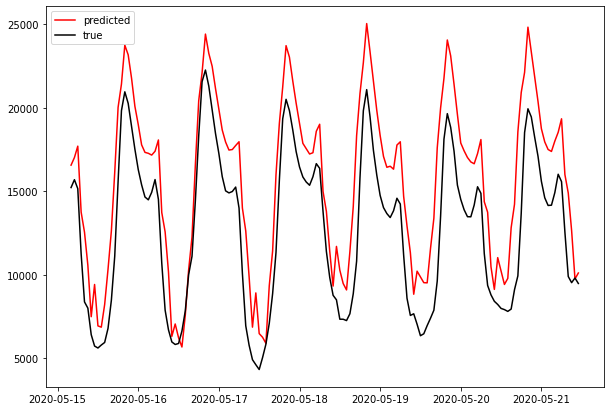

In [85]:
print(f"RMSE = {np.sqrt(mean_squared_error(predictions['net_demand_true'],predictions['net_demand_prediction']))}")
plt.figure(figsize=(10,7))
plt.plot(predictions.index,predictions['net_demand_prediction'],'r-',label='predicted')
plt.plot(predictions.index,predictions['net_demand_true'],'k-',label='true')
plt.legend();